<a href="https://colab.research.google.com/github/sunandhini96/ERA_S7/blob/main/ERA1S7_Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 3 :
Dataset : MNIST
Applied : for model_2 + step lr
(to improve performance )

In [ ]:
!git clone "https://github.com/sunandhini96/ERA_S7.git"

In [ ]:
cd /content/ERA_S7

In [ ]:
pwd

In [ ]:
!python model.py

In [ ]:
from model import *

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_3().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,728
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,080
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1545822024345398 Batch_id=937 Accuracy=89.67: 100%|██████████| 938/938 [00:50<00:00, 18.54it/s]



Test set: Average loss: 0.0636, Accuracy: 9816/10000 (98.16%)

EPOCH: 1


Loss=0.05247095227241516 Batch_id=937 Accuracy=97.43: 100%|██████████| 938/938 [00:45<00:00, 20.58it/s]



Test set: Average loss: 0.0545, Accuracy: 9825/10000 (98.25%)

EPOCH: 2


Loss=0.01090412586927414 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:47<00:00, 19.58it/s]



Test set: Average loss: 0.0444, Accuracy: 9845/10000 (98.45%)

EPOCH: 3


Loss=0.011959541589021683 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:52<00:00, 17.76it/s]



Test set: Average loss: 0.0334, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.012834731489419937 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:49<00:00, 18.92it/s]



Test set: Average loss: 0.0353, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.09096255153417587 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:49<00:00, 19.00it/s]



Test set: Average loss: 0.0380, Accuracy: 9879/10000 (98.79%)

EPOCH: 6


Loss=0.0066528040915727615 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:51<00:00, 18.28it/s]



Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.018593179062008858 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:51<00:00, 18.14it/s]



Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.12344025075435638 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:52<00:00, 17.75it/s]



Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.04238898679614067 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:55<00:00, 17.03it/s]



Test set: Average loss: 0.0229, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.014654296450316906 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:53<00:00, 17.50it/s]



Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.025395750999450684 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:49<00:00, 19.13it/s]



Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.02492782287299633 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:47<00:00, 19.78it/s]



Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.006124862004071474 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:46<00:00, 20.14it/s]



Test set: Average loss: 0.0209, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.012608533725142479 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:44<00:00, 20.98it/s]



Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

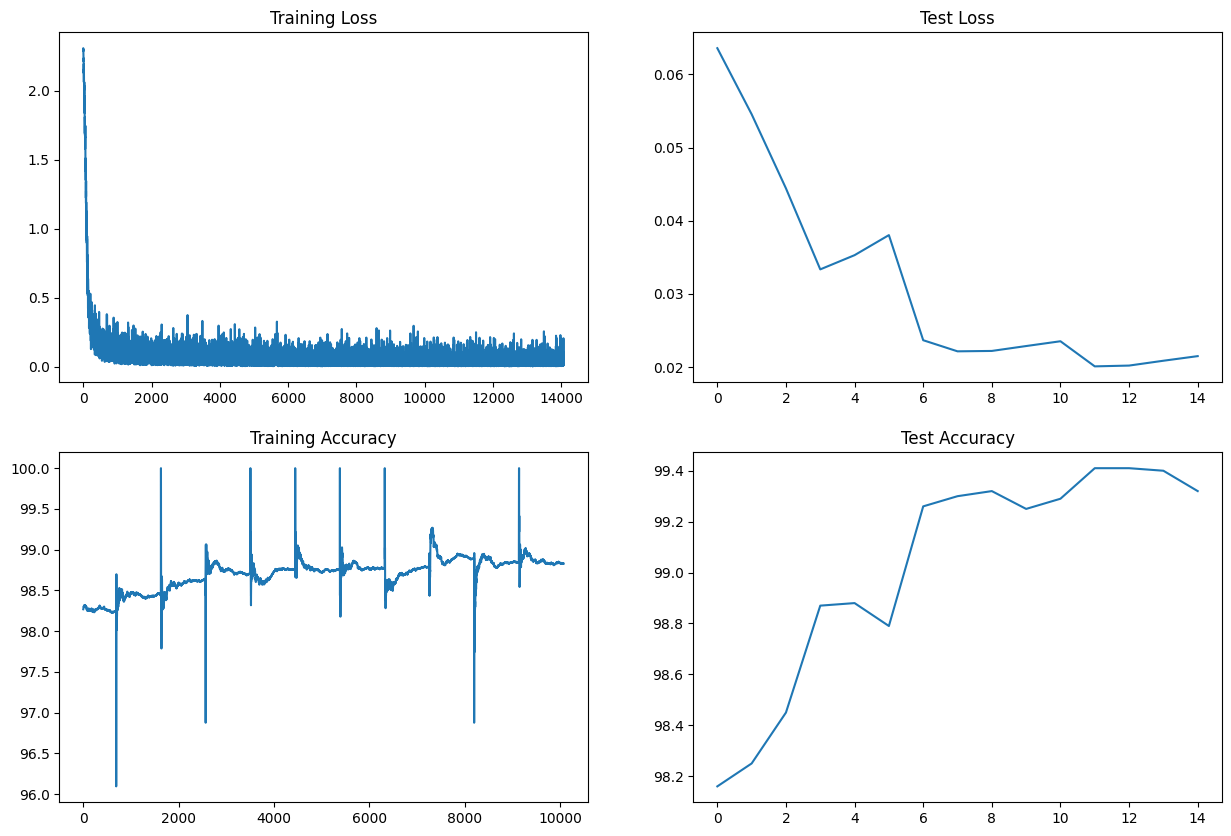

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
t=[t.cpu().item() for t in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
-> We added step lr to improve performance consistently.
## Results:
-> Parameters: 7.7k

-> Best Train Accuracy: 98.89

-> Best Test Accuracy: 99.41

## Analysis:
-> model test accuracy 99.41 % epoch 11 and 12.